In [1]:
%pip install pytorch_lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.6/890.6 kB 50.6 MB/s eta 0:00:00


In [2]:
import torch
from torch import nn
import torch.quantization
import pytorch_lightning as pl
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, Callback
from pytorch_lightning.loggers import TensorBoardLogger
import pandas as pd
import numpy as np

In [3]:
import requests

url = "https://www.dropbox.com/scl/fi/x2eh2yil56rgu5id1fwbm/cnn_data1.csv?rlkey=7bltxkitlwdnuirw08r2ysuv4&st=5z04ff8s&dl=1"
response = requests.get(url)

# Save the file locally
with open('cnn_data1.csv', 'wb') as file:
    file.write(response.content)

In [4]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

def plot_data_hist(df):
    # Define figure size and layout for subplots
    fig, axs = plt.subplots(3, 5, figsize=(15, 15), dpi=80)

    # List of columns to plot histograms for
    columns = ['Activation Function', 'Total Activations', 'Total Parameters', 'Batch Size',
               'Total_Activations_Batch_Size', 'Conv2d Count','BatchNorm2d Count', 'Dropout Count',
               'AdaptiveAvgPool2d Count', 'Linear Count', 'Input Size (MB)', 'Forward/Backward Pass Size (MB)',
               'Params Size (MB)', 'Estimated Total Size (MB)', 'Max GPU Memory (MiB)', 'architecture']

    # Loop over the axes and columns to create histograms
    for ax, col in zip(axs.ravel(), columns):
        if pd.api.types.is_numeric_dtype(df[col]):
            ax.hist(df[col], bins=200)
            ax.set_xlabel(col)
            ax.set_ylabel('count')
        else:
            print(f"Skipping non-numeric column: {col}")

    # Adjust layout for better readability
    plt.tight_layout()
    plt.show()


0       39517
1       36831
2        6293
3        6475
4        2779
        ...  
8995    40123
8996    38637
8997    26097
8998    39617
8999     4321
Name: Max GPU Memory (MiB), Length: 9000, dtype: int64
#datapoints:  9000
0       39517
1       42000
2        6293
3        6475
4        2779
        ...  
8995    42000
8996    42000
8997    26097
8998    42000
8999     4321
Name: Max GPU Memory (MiB), Length: 9000, dtype: int64
#datapoints:  9000
Index(['Activation Function', 'Total Activations', 'Total Parameters',
       'Batch Size', 'Total_Activations_Batch_Size', 'Conv2d Count',
       'BatchNorm2d Count', 'Dropout Count', 'AdaptiveAvgPool2d Count',
       'Linear Count', 'Input Size (MB)', 'Forward/Backward Pass Size (MB)',
       'Params Size (MB)', 'Estimated Total Size (MB)', 'Max GPU Memory (MiB)',
       'architecture'],
      dtype='object')
Activation Function | max :  Tanh | min:  ELU
Total Activations | max :  5317481490 | min:  24514
Total Parameters | max :  32930

<Figure size 10000x800 with 0 Axes>

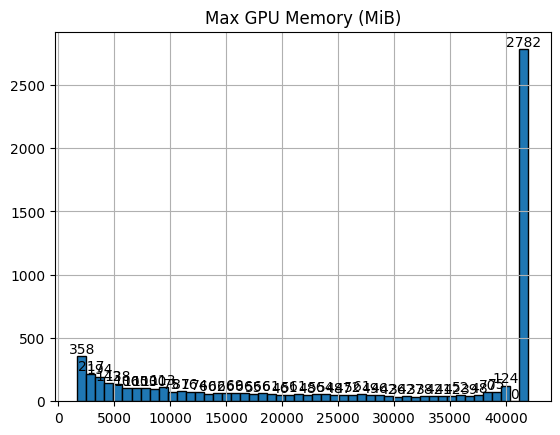

In [5]:
csv_file_path = "cnn_data1.csv"  # Replace with the actual path to the produced CSV file

# Load the CSV into a DataFrame and assign it to the desired column names
df = pd.read_csv(csv_file_path)


print(df['Max GPU Memory (MiB)'])
print("#datapoints: ", len(df))
# print(df.columns)

df['Total_Activations_Batch_Size'] = df['Total Activations'] * df['Batch Size']

# training tasks crashed because of OOM, should be put aside (filter out)
# df = df.loc[df['Status'] != 'OOM_CRASH']

df.loc[df['Status'] == 'OOM_CRASH', 'Max GPU Memory (MiB)'] = 42000


print(df['Max GPU Memory (MiB)'])

print("#datapoints: ", len(df))


# dropping lines that they have NaN values as they will cause error in the next steps
# df = df.dropna()

df = df.dropna(subset=['Activation Function'])


# filtering out the architectures with dens and residual values
df = df[~df['architecture'].isin(['residual', 'dense'])]

# df = df[df['BatchNorm2d Count'] == 0]
# df = df[df['Dropout Count'] == 0]


df = df[['Activation Function', 'Total Activations', 'Total Parameters', 'Batch Size',
         'Total_Activations_Batch_Size', 'Conv2d Count','BatchNorm2d Count', 'Dropout Count',
         'AdaptiveAvgPool2d Count', 'Linear Count', 'Input Size (MB)', 'Forward/Backward Pass Size (MB)',
         'Params Size (MB)', 'Estimated Total Size (MB)', 'Max GPU Memory (MiB)', 'architecture']]

# print(df.columns)

# Map the existing columns to your desired column structure

# df = df.rename(columns={
#     'Max GPU Memory (MiB)': 'real_memory_usage',
#     'Conv2d Count': 'conv2d_layers',
#     'Activation Function': 'activation_function',
#     'Total_Activations_Batch_Size': 'total_activation_mul_batch_size',
#     'Batch Size': 'batch_size',
#     'Total Parameters': 'all_parameters',
#     'Total Activations': 'all_activations',
#     'Activations-Params': 'params_activation_list',
#     'BatchNorm2d Count': 'batch_norm2d_layer',
#     'Dropout Count': 'dropout_layers',
#     'Linear Count': 'linear_layers',
#     'AdaptiveAvgPool2d Count': 'adaptive_avg_pool2d_layers'
# })

print(df.columns)


columns_to_analyze = ['Activation Function', 'Total Activations', 'Total Parameters', 'Batch Size',
                      'Total_Activations_Batch_Size', 'Conv2d Count','BatchNorm2d Count', 'Dropout Count',
                      'AdaptiveAvgPool2d Count', 'Linear Count', 'Input Size (MB)', 'Forward/Backward Pass Size (MB)',
                      'Params Size (MB)', 'Estimated Total Size (MB)', 'Max GPU Memory (MiB)']
for col in columns_to_analyze:
    if col == 'activation_function':
      continue
    print(f'{col} | max : ', df[col].max(), '| min: ', df[col].min())
print('len dataset: ', len(df))

# print(df.dtypes)


print("#datapoints: ", len(df))


# Plotting the histogram of 'Max GPU Memory (MiB)' with increased figure size and labeled bins
plt.figure(figsize=(100, 8))  # Increase the size of the figure
ax = df[['Max GPU Memory (MiB)']].hist(bins=50, edgecolor='black')

# Adding labels to the bins
for ax in plt.gcf().axes:
    for patch in ax.patches:
        # Get the coordinates and height of each bar (bin)
        height = patch.get_height()
        width = patch.get_width()
        # Calculate the position where the text will be displayed
        bin_center = patch.get_x() + width / 2
        # Display the height (number of items in each bin)
        ax.text(bin_center, height, int(height), ha='center', va='bottom')

plt.show()

Skipping non-numeric column: Activation Function


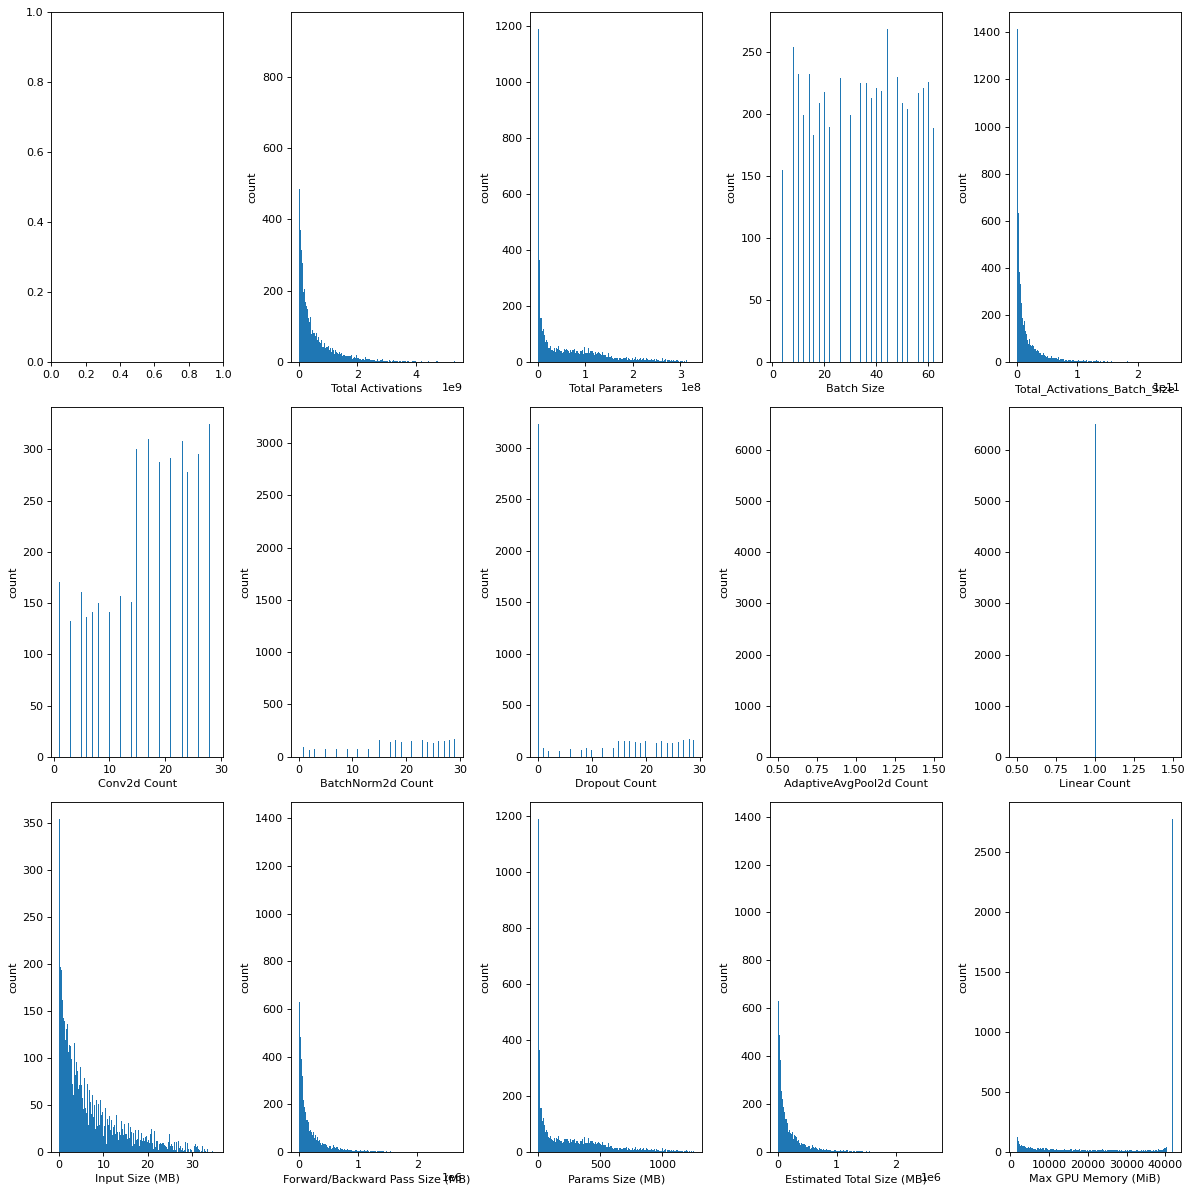

In [6]:
plot_data_hist(df)

# having activations functions as two separate columns

In [7]:
# List of activation functions
activations = ['ELU', 'GELU', 'LeakyReLU', 'Mish', 'PReLU', 'ReLU', 'SELU', 'SiLU', 'Softplus', 'Tanh']

# Function to create positional encoding
def positional_encoding_2d(num_states):
    positions = []
    for i in range(num_states):
        position = (np.sin(i * np.pi / num_states), np.cos(i * np.pi / num_states))
        positions.append(position)
    return np.array(positions)

# Generate positional encodings
positional_encodings = positional_encoding_2d(len(activations))
activation_to_encoding = {activation: positional_encodings[i] for i, activation in enumerate(activations)}

# Apply positional encoding to 'activation_function' column
df['activation_encoding_sin'] = df['Activation Function'].map(lambda x: activation_to_encoding[x][0])
df['activation_encoding_cos'] = df['Activation Function'].map(lambda x: activation_to_encoding[x][1])

print(df.columns)


Index(['Activation Function', 'Total Activations', 'Total Parameters',
       'Batch Size', 'Total_Activations_Batch_Size', 'Conv2d Count',
       'BatchNorm2d Count', 'Dropout Count', 'AdaptiveAvgPool2d Count',
       'Linear Count', 'Input Size (MB)', 'Forward/Backward Pass Size (MB)',
       'Params Size (MB)', 'Estimated Total Size (MB)', 'Max GPU Memory (MiB)',
       'architecture', 'activation_encoding_sin', 'activation_encoding_cos'],
      dtype='object')


In [8]:
df

,Activation Function,Total Activations,Total Parameters,Batch Size,Total_Activations_Batch_Size,Conv2d Count,BatchNorm2d Count,Dropout Count,AdaptiveAvgPool2d Count,Linear Count,Input Size (MB),Forward/Backward Pass Size (MB),Params Size (MB),Estimated Total Size (MB),Max GPU Memory (MiB),architecture,activation_encoding_sin,activation_encoding_cos
0,GELU,195826172,1864805,62,12141222664,22,0,22,1,1,21.70,123506.48,7.11,123535.29,39517,uniform,0.309017,9.510565e-01
1,SELU,306385536,32924348,46,14093734656,11,11,11,1,1,2.30,134408.32,125.60,134536.22,42000,pyramid,0.951057,-3.090170e-01
2,ELU,27443119,1730036,34,933066046,14,0,0,1,1,3.06,10678.04,6.60,10687.70,6293,uniform,0.000000,1.000000e+00
3,ELU,119603463,731920,10,1196034630,16,16,16,1,1,2.90,11406.30,2.79,11411.99,6475,uniform,0.000000,1.000000e+00
4,ReLU,11111315,2960902,18,200003670,12,12,0,1,1,0.18,2034.54,11.29,2046.01,2779,gradual,1.000000,6.123234e-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8994,Tanh,261412634,69541327,8,2091301072,19,19,19,1,1,0.64,19944.16,265.28,20210.08,12765,hourglass,0.309017,-9.510565e-01
8995,ELU,1224102531,174087245,14,17137435434,21,21,21,1,1,2.66,163435.30,664.09,164102.05,42000,hourglass,0.000000,1.000000e+00
8996,ELU,964897150,206115033,26,25087325900,21,0,21,1,1,4.68,255201.44,786.27,255992.39,42000,hourglass,0.000000,1.000000e+00
8997,PReLU,273489723,250091310,22,6016773906,29,0,29,1,1,0.88,61205.76,954.02,62160.66,26097,hourglass,0.951057,3.090170e-01


# filter the data


In [9]:
# in case wanna filter some of the data use this code

# df_filtered = df[df['layers'] <= 64]
# df_filtered = df_filtered[df_filtered['all_parameters'] <= 10e6]
# df_filtered = df_filtered[df_filtered['batch_size'] <= 64]
# df_filtered = df_filtered[df_filtered['all_activations'] <= 1e5]
# print(len(df_filtered))
# plot_data_hist(df_filtered)


# classification

Index(['Total Activations', 'Total Parameters', 'Batch Size',
       'Total_Activations_Batch_Size', 'Conv2d Count', 'BatchNorm2d Count',
       'Dropout Count', 'Input Size (MB)', 'Forward/Backward Pass Size (MB)',
       'Params Size (MB)', 'Estimated Total Size (MB)'],
      dtype='object') 6516    Total Activations  Total Parameters  Batch Size  \
0          -0.481515         -0.863827    1.670786   
1          -0.312325         -0.433732    0.742251   
2          -0.739192         -0.865693    0.045850   
3          -0.598158         -0.879514   -1.346953   
4          -0.764184         -0.848649   -0.882685   

   Total_Activations_Batch_Size  Conv2d Count  BatchNorm2d Count  \
0                     -0.179003      0.558834          -0.855547   
1                     -0.102302     -0.818999           0.200458   
2                     -0.619294     -0.443226          -0.855547   
3                     -0.608964     -0.192711           0.680460   
4                     -0.648091    

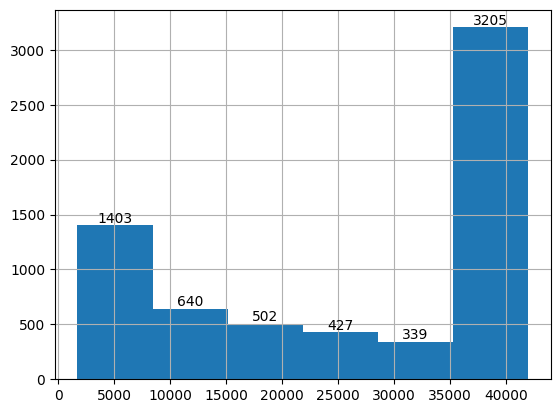

In [10]:
columns_to_normalize = ['Total Activations', 'Total Parameters', 'Batch Size', 'Total_Activations_Batch_Size',
                        'Conv2d Count', 'BatchNorm2d Count', 'Dropout Count', 'Input Size (MB)',
                        'Forward/Backward Pass Size (MB)',
                        'Params Size (MB)', 'Estimated Total Size (MB)']



from sklearn.preprocessing import StandardScaler
# # Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler and transform the data
df_normalized = pd.DataFrame(scaler.fit_transform(df[columns_to_normalize]), columns=columns_to_normalize)

# no normalization
# df_normalized = df


print(df_normalized.columns, len(df_normalized), df_normalized.head())

print(df[["Activation Function"]])

print(df.columns)

df['Max GPU Memory (MiB)'].hist(bins=6)

# Adding labels to the bins
for ax in plt.gcf().axes:
    for patch in ax.patches:
        # Get the coordinates and height of each bar (bin)
        height = patch.get_height()
        width = patch.get_width()
        # Calculate the position where the text will be displayed
        bin_center = patch.get_x() + width / 2
        # Display the height (number of items in each bin)
        ax.text(bin_center, height, int(height), ha='center', va='bottom')

plt.show()

# Hard Labeling

In [11]:
import pandas as pd

# Define bins where values between 0-10000 fall into class 0, 10000-20000 into class 1, and so on
# bins = [0, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, float('inf')]

# bins = [i*2000 for i in range(0, 23)]

# bins = [0, 8000, 16000, 24000, 32000, 40000, 50000, ]
bins = [0, 10000, 20000, 30000, 40000, 45000]

# Define labels corresponding to the bins
labels = [i for i in range(0, len(bins)-1)]


print(labels, len(labels), "\n", bins)

# Use pd.cut() to create a new column with labels based on the bins
df['memory_usage_label'] = pd.cut(df['Max GPU Memory (MiB)'], bins=bins, labels=labels, right=False)

# Display some rows where 'memory_usage_label' falls into the last bin (infinite)
inf_rows = df.loc[df['memory_usage_label'] == labels[2]]  # labels[-1] is the label for the last bin

print(inf_rows.tail())

[0, 1, 2, 3, 4] 5 
 [0, 10000, 20000, 30000, 40000, 45000]
     Activation Function  Total Activations  Total Parameters  Batch Size  \
8961               PReLU          192001852           3172451          30   
8973               PReLU          103739303           4559756          60   
8979                ReLU          139955209          76639704          30   
8988                SiLU          127245558          89606972          30   
8997               PReLU          273489723         250091310          22   

      Total_Activations_Batch_Size  Conv2d Count  BatchNorm2d Count  \
8961                    5760055560            16                  0   
8973                    6224358180            29                 29   
8979                    4198656270            17                 17   
8988                    3817366740            18                 18   
8997                    6016773906            29                  0   

      Dropout Count  AdaptiveAvgPool2d Count  Linea

In [12]:
unique_values = df['memory_usage_label'].unique()

# Print the unique values
print(unique_values, len(labels))

[3, 4, 0, 2, 1]
Categories (5, int64): [0 < 1 < 2 < 3 < 4] 5


In [13]:
df['memory_usage_label'].values

[3, 4, 0, 0, 0, ..., 1, 4, 4, 2, 4]
Length: 6516
Categories (5, int64): [0 < 1 < 2 < 3 < 4]

In [41]:
import pandas as pd

# Sample DataFrame for demonstration
# df = pd.DataFrame({
#     'Max GPU Memory (MiB)': [1000, 5000, 15000, 22000, 30000, 45000, 52000, 60000] * 10
# })

# Define your bins and labels
# bins = [0, 8000, 16000, 24000, 32000, 40000, 50000]
bins = [0, 10000, 20000, 30000, 40000, 50000]

labels = [i for i in range(0, len(bins) - 1)]

# Create the 'memory_usage_label' column
df['memory_usage_label'] = pd.cut(df['Max GPU Memory (MiB)'], bins=bins, labels=labels, right=False)

# Count instances per class
class_counts = df['memory_usage_label'].value_counts()

# Determine the target count (minimum count)
target_count = class_counts.min()

# Create a balanced DataFrame
balanced_df = pd.DataFrame()

for label in labels:
    # Select samples for each label
    if class_counts[label] > target_count:
        # Downsample if there are more samples than the target count
        samples = df[df['memory_usage_label'] == label].sample(target_count, random_state=42)
    else:
        # Upsample if there are fewer samples than the target count
        samples = df[df['memory_usage_label'] == label].sample(target_count, replace=True, random_state=42)

    balanced_df = pd.concat([balanced_df, samples])

# Reset index of the balanced DataFrame
balanced_df.reset_index(drop=True, inplace=True)

# Display the balanced DataFrame and the counts of each class
print(balanced_df['memory_usage_label'].value_counts())
print(balanced_df)


memory_usage_label
0    617
1    617
2    617
3    617
4    617
Name: count, dtype: int64
     Activation Function  Total Activations  Total Parameters  Batch Size  \
0                   GELU          119925931           7781325           8   
1               Softplus           21383735           1400756          32   
2                    ELU           34226049            317477          26   
3                   SiLU           13955893           2587543          50   
4                   SELU           26805311          25538956          58   
...                  ...                ...               ...         ...   
3080                SELU         1186619012          70681000          58   
3081            Softplus          491452744         164891877          50   
3082                ReLU         1522623256         113503004          18   
3083                SiLU         1693354920          67826892          30   
3084                GELU          594350146          57967545  

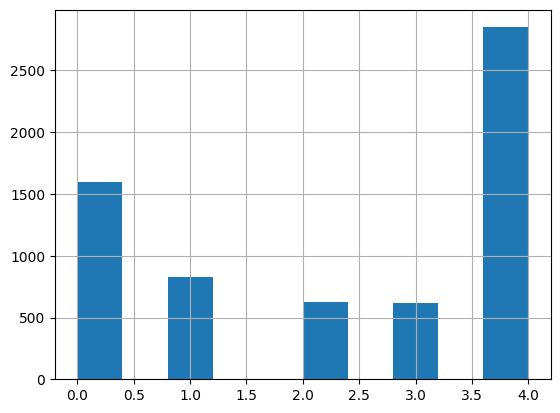

<Axes: >

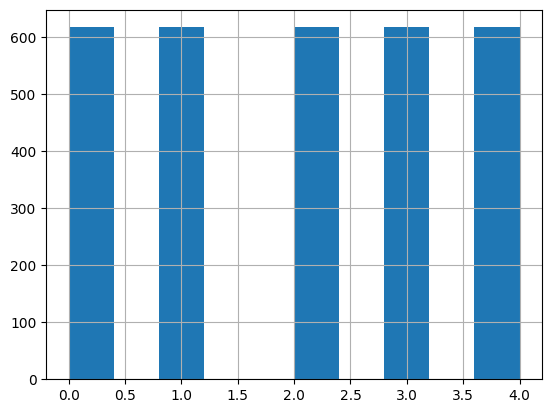

In [42]:
df['memory_usage_label'].hist()

plt.show()

balanced_df['memory_usage_label'].hist()

In [43]:
from sklearn.model_selection import train_test_split
x_train, x_temp, y_train, y_temp = train_test_split(
    df[['Total Activations', 'Total Parameters', 'Batch Size', 'Total_Activations_Batch_Size',
                        'Conv2d Count', 'BatchNorm2d Count', 'Dropout Count', 'activation_encoding_sin','activation_encoding_cos',
                        # 'Input Size (MB)', 'Forward/Backward Pass Size (MB)', 'Params Size (MB)', 'Estimated Total Size (MB)'
                        ]].values, df['memory_usage_label'].values, test_size=0.3, random_state=42)

x_test, x_val, y_test, y_val = train_test_split(
    x_temp, y_temp, test_size=0.66, random_state=42)

print('total data size: ', len(df))
print(f"train size {len(x_train)}, val size: {len(x_val)}, test size: {len(x_test)}")

total data size:  6516
train size 4561, val size: 1291, test size: 664


In [44]:
from torch.utils.data import Dataset, DataLoader

# Custom Dataset Class
class CustomDataset(Dataset):
    def __init__(self, inputs, targets):
        # Store the input and target data
        self.inputs = torch.tensor(inputs, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.float32)

    def __len__(self):
        # Returns the total number of samples
        return len(self.inputs)

    def __getitem__(self, idx):
        # Return a single sample (input, target pair)
        return self.inputs[idx], self.targets[idx]

train_dataloader = DataLoader(CustomDataset(x_train, y_train), 512, num_workers=2, shuffle=True)
val_dataloader = DataLoader(CustomDataset(x_val, y_val), 512, num_workers=2)
test_dataloader = DataLoader(CustomDataset(x_test, y_test),1, num_workers=1)
x, y = next(iter(train_dataloader))
print(f"input shape: {x.shape}, output shape: {y.shape}")

input shape: torch.Size([512, 9]), output shape: torch.Size([512])


In [45]:
class FC_base(nn.Module):
    def __init__(self, input_features, output_features, base_features):
        super(FC_base, self).__init__()

        # Define the network architecture
        self.fc1 = nn.Linear(input_features, base_features)
        self.bn1 = nn.BatchNorm1d(base_features)
        self.fc2 = nn.Linear(base_features, base_features)
        self.bn2 = nn.BatchNorm1d(base_features)
        self.fc3 = nn.Linear(base_features, base_features)
        self.bn3 = nn.BatchNorm1d(base_features)
        self.fc4 = nn.Linear(base_features, base_features)
        self.bn4 = nn.BatchNorm1d(base_features)
        self.fc5 = nn.Linear(base_features, base_features)
        self.bn5 = nn.BatchNorm1d(base_features)
        # self.fc6 = nn.Linear(base_features//2, base_features//2)
        # self.bn6 = nn.BatchNorm1d(base_features//2)

        self.final = nn.Linear(base_features, output_features)
        # self.dropout = nn.Dropout(p=0.0)
        # Activation function
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.relu(self.bn3(self.fc3(x)))
        x = self.relu(self.bn4(self.fc4(x)))
        x = self.relu(self.bn5(self.fc5(x)))
        # x = self.relu(self.bn6(self.fc6(x)))
        x = self.final(x)
        return x

In [46]:
from pytorch_lightning import seed_everything

seed = 13  # Set your desired seed
seed_everything(seed, workers=True)
torch.use_deterministic_algorithms(False)


INFO:lightning_fabric.utilities.seed:Seed set to 13


In [47]:
class classification_gpu_usage(pl.LightningModule):
    def __init__(self, output_size):
        super(classification_gpu_usage, self).__init__()
        # Define your model
        self.model = FC_base(input_features=9, output_features=output_size, base_features=8)
        self.criterion = nn.CrossEntropyLoss()
        # self.criterion = nn.BCEWithLogitsLoss()
        self.output_size = output_size

        # Apply weight initialization
        self.apply(self._initialize_weights)

    def _initialize_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)  # Xavier uniform initialization
            if module.bias is not None:
                nn.init.zeros_(module.bias)  # Initialize bias to zeros


    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch[0], batch[1]
        y = y.long()
        # Apply label smoothing to the target labels
        # smoothed_labels = smooth_labels(y, self.output_size, self.smoothing)

        # assert (y >= 0).all() and (y < self.output_size).all(), "Labels are out of bounds."


        logits = self.forward(x)
        loss = self.criterion(logits, y)

        # Calculate accuracy
        acc = (logits.argmax(dim=1) == y).float().mean()

        # Log loss and accuracy
        self.log('train_loss', loss, on_epoch=True, on_step=False)
        self.log('train_acc', acc, on_epoch=True, on_step=False)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch[0], batch[1]
        y = y.long()

        # assert (y >= 0).all() and (y < self.output_size).all(), "Labels are out of bounds."

        logits = self.forward(x)
        loss = self.criterion(logits, y)
        # Calculate accuracy
        acc = (logits.argmax(dim=1) == y).float().mean()

        # Log loss and accuracy
        self.log('val_loss', loss, on_epoch=True, on_step=False, prog_bar=True)
        self.log('val_acc', acc, on_epoch=True, on_step=False, prog_bar=True)

        return loss

    def configure_optimizers(self):
        optimizer = Adam(self.parameters(), lr=0.0001)


        return optimizer
        # # Use a scheduler that doesn't require setting the learning rate explicitly
        # scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
        # return {
        #     'optimizer': optimizer,
        #     'lr_scheduler': {
        #         'scheduler': scheduler,
        #         'monitor': 'val_loss',
        #         'frequency': 1
        #     }
        # }
        # return optimizer

In [48]:
from torchsummary import summary

device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(device)
print(len(labels))

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=True, mode='min')


classifier_model = classification_gpu_usage(output_size = len(labels)).to(device)

summary(classifier_model, input_size=(9,), device=device)

cuda
5
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 8]              80
       BatchNorm1d-2                    [-1, 8]              16
              ReLU-3                    [-1, 8]               0
            Linear-4                    [-1, 8]              72
       BatchNorm1d-5                    [-1, 8]              16
              ReLU-6                    [-1, 8]               0
            Linear-7                    [-1, 8]              72
       BatchNorm1d-8                    [-1, 8]              16
              ReLU-9                    [-1, 8]               0
           Linear-10                    [-1, 8]              72
      BatchNorm1d-11                    [-1, 8]              16
             ReLU-12                    [-1, 8]               0
           Linear-13                    [-1, 8]              72
      BatchNorm1d-14            

In [ ]:

classifier_model.train()
trainer = pl.Trainer(
    max_epochs=200,
    callbacks=[early_stopping],
)

# Train the model
trainer.fit(classifier_model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | FC_base          | 493    | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
493       Trainable params
0         Non-trainable params
493       Total params
0.002     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (9) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 1.652


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.647


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 1.631


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 1.614


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 1.598


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 1.578


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 1.559


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 1.539


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 1.517


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 1.497


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 1.472


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 1.450


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 1.429


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 1.403


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 1.374


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 1.353


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 1.336


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 1.323


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 1.303


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 1.285


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 1.274


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 1.263


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 1.254


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 1.237


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 1.228


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 1.220


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 1.207


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 1.191


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 1.179


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 1.168


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 1.160


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.154


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 1.145


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.142


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 1.131


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 1.122


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 1.114


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 1.100


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 1.087


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 1.080


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.074


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.072


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.066


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 1.059


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.055


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 1.047


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.042


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.039


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.033


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.030


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.025


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.019


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.015


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.010


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.005


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.001


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.995


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.990


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.987


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.982


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.979


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.975


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.972


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.971


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.968


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.960


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.958


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.955


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.952


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.950


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.945


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.943


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.939


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.935


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.930


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.926


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.923


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.920


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.918


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.911


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.907


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.907


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.900


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.895


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.891


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.886


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.883


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.881


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.876


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.875


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.869


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.867


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.860


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.856


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.852


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.847


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.844


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.844


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.840


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.837


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.834


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.833


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.829


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.827


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.824


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.818


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.818


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.811


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.808


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.805


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.801


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.799


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.795


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.794


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.790


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.785


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.784


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.782


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.775


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.771


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.767


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.762


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.762


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.757


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.752


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.750


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.748


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.745


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.742


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.741


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.736


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.731


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.729


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.728


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.726


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.721


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.720


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.717


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.712


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.712


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.707


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.704


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.699


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.698


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.695


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.694


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.689


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.688


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.685


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.682


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.679


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.676


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.674


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.671


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.669


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.666


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.664


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.661


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.660


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.656


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.653


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.652


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.649


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.647


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.645


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.644


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.640


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.636


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.634


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.633


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.632


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.630


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.626


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.625


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.623


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.621


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.616


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.615


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.613


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.612


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.610


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.608


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.606


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.604
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


In [23]:
classifier_model.eval()
pred_list, gt = list(), list()
with torch.no_grad():
    for test_data in test_dataloader:
        pred = classifier_model(test_data[0])
        if test_data[1].item() != torch.argmax(pred, 1).item():
            print(f"prediction: {torch.softmax(pred, 1)}, ground truth: {test_data[1]}")
        gt.append(test_data[1].item())
        pred_list.append(torch.argmax(pred, 1).item())

prediction: tensor([[0.0668, 0.1604, 0.3633, 0.2225, 0.0918, 0.0951]]), ground truth: tensor([3.])
prediction: tensor([[0.3986, 0.5241, 0.0391, 0.0129, 0.0164, 0.0090]]), ground truth: tensor([0.])
prediction: tensor([[0.0354, 0.0131, 0.2694, 0.3884, 0.2458, 0.0479]]), ground truth: tensor([2.])
prediction: tensor([[0.2581, 0.5558, 0.0895, 0.0408, 0.0305, 0.0254]]), ground truth: tensor([0.])
prediction: tensor([[0.2876, 0.5774, 0.0650, 0.0277, 0.0241, 0.0183]]), ground truth: tensor([0.])
prediction: tensor([[0.0609, 0.0976, 0.3891, 0.2603, 0.1157, 0.0764]]), ground truth: tensor([4.])
prediction: tensor([[0.4679, 0.4767, 0.0288, 0.0087, 0.0121, 0.0057]]), ground truth: tensor([0.])
prediction: tensor([[0.2794, 0.5737, 0.0705, 0.0309, 0.0254, 0.0200]]), ground truth: tensor([0.])
prediction: tensor([[0.0225, 0.0081, 0.1263, 0.2992, 0.3877, 0.1563]]), ground truth: tensor([3.])
prediction: tensor([[0.0056, 0.0029, 0.0196, 0.0568, 0.2889, 0.6261]]), ground truth: tensor([4.])
prediction

In [40]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
def below_diagonal_sum_rate(confusion_matrix):
    # Convert to a numpy array for easier manipulation if not already
    confusion_matrix = np.array(confusion_matrix)

    # Sum the elements below the main diagonal (excluding the diagonal itself)
    below_diag_sum = np.sum(np.tril(confusion_matrix, k=-1))

    # Get the total number of data points
    total_data_points = np.sum(confusion_matrix)

    # Calculate the rate by dividing below-diagonal sum by total data points
    rate = below_diag_sum / total_data_points

    return rate

def calculate_metrics(gt, preds):
    # Calculate the various metrics
    accuracy = accuracy_score(gt, preds)
    precision = precision_score(gt, preds, average='weighted')  # Use 'weighted' to handle class imbalance
    recall = recall_score(gt, preds, average='weighted')
    f1 = f1_score(gt, preds, average='weighted')
    cm = confusion_matrix(gt, preds)

    # Print the results
    print("Accuracy: {:.4f}".format(accuracy))
    print("Precision: {:.4f}".format(precision))
    print("Recall: {:.4f}".format(recall))
    print("F1-Score: {:.4f}".format(f1))
    print("Below Diagonal Sum Rate: {:.4f}".format(below_diagonal_sum_rate(cm)))
    print("\nConfusion Matrix:")
    print(cm)

    # Full classification report
    print("\nClassification Report:")
    print(classification_report(gt, preds))

calculate_metrics(gt, pred_list)


Accuracy: 0.7455
Precision: 0.8093
Recall: 0.7455
F1-Score: 0.7490
Below Diagonal Sum Rate: 0.0617

Confusion Matrix:
[[ 66  76   0   0   0   0]
 [  0  65  25   0   0   0]
 [  0   3  34   9   1   0]
 [  0   1  15  29   8   0]
 [  0   0   1  16  26   9]
 [  0   0   0   1   4 275]]

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.46      0.63       142
         1.0       0.45      0.72      0.55        90
         2.0       0.45      0.72      0.56        47
         3.0       0.53      0.55      0.54        53
         4.0       0.67      0.50      0.57        52
         5.0       0.97      0.98      0.98       280

    accuracy                           0.75       664
   macro avg       0.68      0.66      0.64       664
weighted avg       0.81      0.75      0.75       664



In [25]:
from sklearn.manifold import TSNE

print(df.columns)

# Initialize the t-SNE model
tsne = TSNE(n_components=2, random_state=43)

# Fit and transform the features

# tsne_results = tsne.fit_transform(df[['all_activations', 'all_parameters', 'batch_size','total_activation_mul_batch_size', 'conv2d_layers','batch_norm2d_layer', 'dropout_layers']])
# tsne_results = tsne.fit_transform(df[['all_activations', 'all_parameters', 'batch_size','total_activation_mul_batch_size', 'conv2d_layers','batch_norm2d_layer']])

tsne_results = tsne.fit_transform(df[['Total Activations', 'Total Parameters', 'Batch Size', 'Total_Activations_Batch_Size',
                        'Conv2d Count', 'BatchNorm2d Count', 'Dropout Count', 'activation_encoding_sin',
                        'activation_encoding_cos', 'Input Size (MB)', 'Forward/Backward Pass Size (MB)',
                        'Params Size (MB)', 'Estimated Total Size (MB)']])

Index(['Activation Function', 'Total Activations', 'Total Parameters',
       'Batch Size', 'Total_Activations_Batch_Size', 'Conv2d Count',
       'BatchNorm2d Count', 'Dropout Count', 'AdaptiveAvgPool2d Count',
       'Linear Count', 'Input Size (MB)', 'Forward/Backward Pass Size (MB)',
       'Params Size (MB)', 'Estimated Total Size (MB)', 'Max GPU Memory (MiB)',
       'architecture', 'activation_encoding_sin', 'activation_encoding_cos',
       'memory_usage_label'],
      dtype='object')


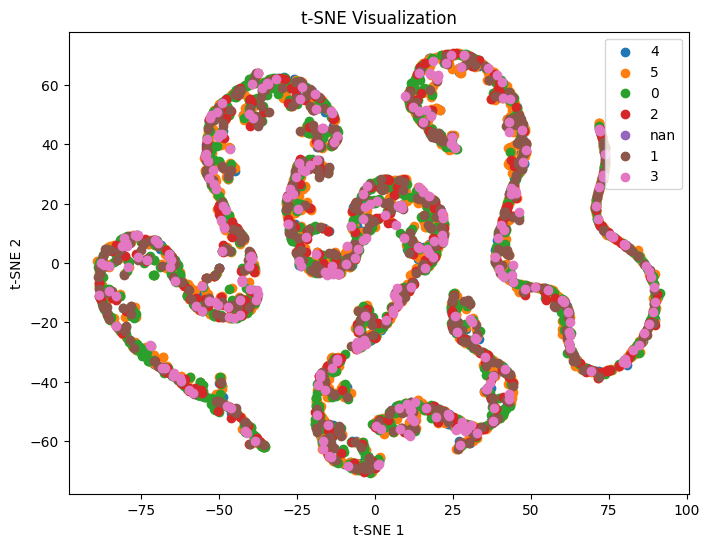

In [26]:
import matplotlib.pyplot as plt

# Create a new DataFrame for the t-SNE results
tsne_df = pd.DataFrame(tsne_results, columns=['tsne1', 'tsne2'])
tsne_df['label'] = df['memory_usage_label']

# Plot the results
plt.figure(figsize=(8, 6))
for label in tsne_df['label'].unique():
    subset = tsne_df[tsne_df['label'] == label]
    plt.scatter(subset['tsne1'], subset['tsne2'], label=label)

plt.title('t-SNE Visualization')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend()
plt.show()


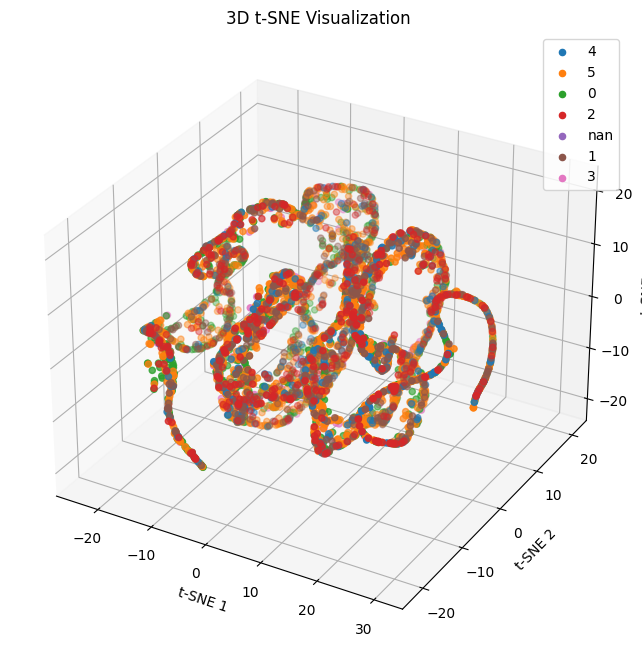

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting

# Initialize the t-SNE model with 3 components
tsne = TSNE(n_components=3, random_state=43)


# Fit and transform the features

tsne_results = tsne.fit_transform(df[['Total Activations', 'Total Parameters', 'Batch Size', 'Total_Activations_Batch_Size',
                        'Conv2d Count', 'BatchNorm2d Count', 'Dropout Count', 'activation_encoding_sin',
                        'activation_encoding_cos', 'Input Size (MB)', 'Forward/Backward Pass Size (MB)',
                        'Params Size (MB)', 'Estimated Total Size (MB)']])

# Create a new DataFrame for the t-SNE results (3 components)
tsne_df = pd.DataFrame(tsne_results, columns=['tsne1', 'tsne2', 'tsne3'])
tsne_df['label'] = df['memory_usage_label']

# Plot the results in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for label in tsne_df['label'].unique():
    subset = tsne_df[tsne_df['label'] == label]
    ax.scatter(subset['tsne1'], subset['tsne2'], subset['tsne3'], label=label)

# Set plot title and labels
ax.set_title('3D t-SNE Visualization')
ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_zlabel('t-SNE 3')

# Add legend
plt.legend()

# Show the plot
plt.show()

# PCA

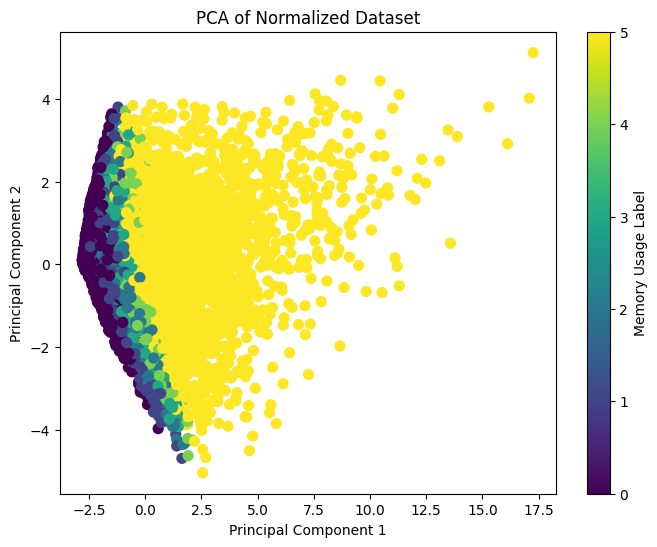

PCA Components:
[[ 0.38269384  0.31272889  0.1087365   0.40649392  0.24404724  0.14768617
   0.15037366  0.00167073 -0.00206964  0.21484776  0.40659826  0.3127289
   0.40671179]
 [-0.04350075 -0.36217284  0.43336075  0.18453221 -0.34094103 -0.20424238
  -0.17978114  0.00645704  0.00353959  0.50232287  0.18899573 -0.36217288
   0.18851199]]
Explained variance ratio:
[0.41094874 0.16091869]


In [28]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler  # Import for normalization

X = df[['Total Activations', 'Total Parameters', 'Batch Size', 'Total_Activations_Batch_Size',
                        'Conv2d Count', 'BatchNorm2d Count', 'Dropout Count', 'activation_encoding_sin',
                        'activation_encoding_cos', 'Input Size (MB)', 'Forward/Backward Pass Size (MB)',
                        'Params Size (MB)', 'Estimated Total Size (MB)']]
y = df['memory_usage_label']  # Output label for coloring

# Normalize the data
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Apply PCA to reduce the dataset to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_normalized)

# Plotting the PCA-reduced data
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', s=50)
plt.colorbar(label='Memory Usage Label')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Normalized Dataset')

# Show the plot
plt.show()

components = pca.components_

# Get the explained variance ratio for each component (optional, to know how much variance each component explains)
explained_variance = pca.explained_variance_ratio_

# Show the components (each row corresponds to a principal component, each column corresponds to the original feature)
print("PCA Components:")
print(components)

# Show the explained variance ratio for each component
print("Explained variance ratio:")
print(explained_variance)

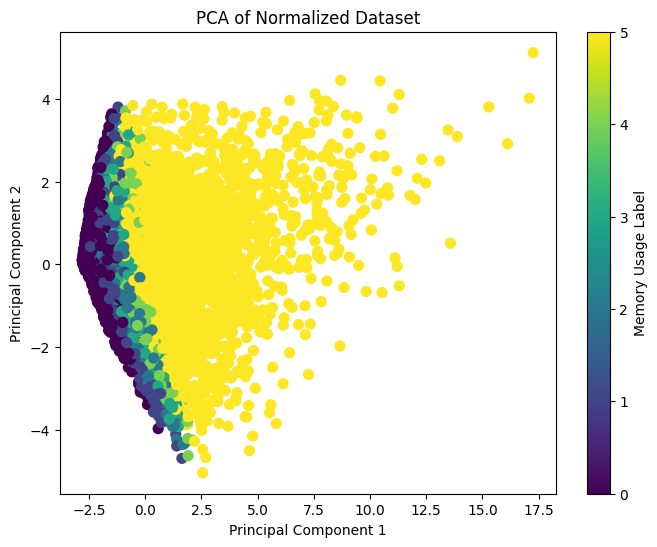

PCA Components:
[[ 0.38269384  0.31272889  0.1087365   0.40649392  0.24404724  0.14768617
   0.15037366  0.00167073 -0.00206964  0.21484776  0.40659826  0.3127289
   0.40671179]
 [-0.04350075 -0.36217284  0.43336075  0.18453221 -0.34094103 -0.20424238
  -0.17978114  0.00645704  0.00353959  0.50232287  0.18899573 -0.36217288
   0.18851199]]
Explained variance ratio:
[0.41094874 0.16091869]


In [29]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler  # Import for normalization

# Assuming you have a pandas DataFrame 'df'
# df = pd.read_csv('your_dataset.csv')  # Uncomment if loading from a file


# Example DataFrame columns: 'layers', 'batch_size', 'all_parameters', 'all_activations', 'memory_usage_label'
# X = df[['all_activations', 'all_parameters', 'batch_size', 'conv2d_layers','batch_norm2d_layer', 'dropout_layers']]  # Input features
X = df[['Total Activations', 'Total Parameters', 'Batch Size', 'Total_Activations_Batch_Size',
                        'Conv2d Count', 'BatchNorm2d Count', 'Dropout Count', 'activation_encoding_sin',
                        'activation_encoding_cos', 'Input Size (MB)', 'Forward/Backward Pass Size (MB)',
                        'Params Size (MB)', 'Estimated Total Size (MB)']]
y = df['memory_usage_label']  # Output label for coloring

# Normalize the data
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Apply PCA to reduce the dataset to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_normalized)

# Plotting the PCA-reduced data
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', s=50)
plt.colorbar(label='Memory Usage Label')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Normalized Dataset')

# Show the plot
plt.show()

components = pca.components_

# Get the explained variance ratio for each component (optional, to know how much variance each component explains)
explained_variance = pca.explained_variance_ratio_

# Show the components (each row corresponds to a principal component, each column corresponds to the original feature)
print("PCA Components:")
print(components)

# Show the explained variance ratio for each component
print("Explained variance ratio:")
print(explained_variance)

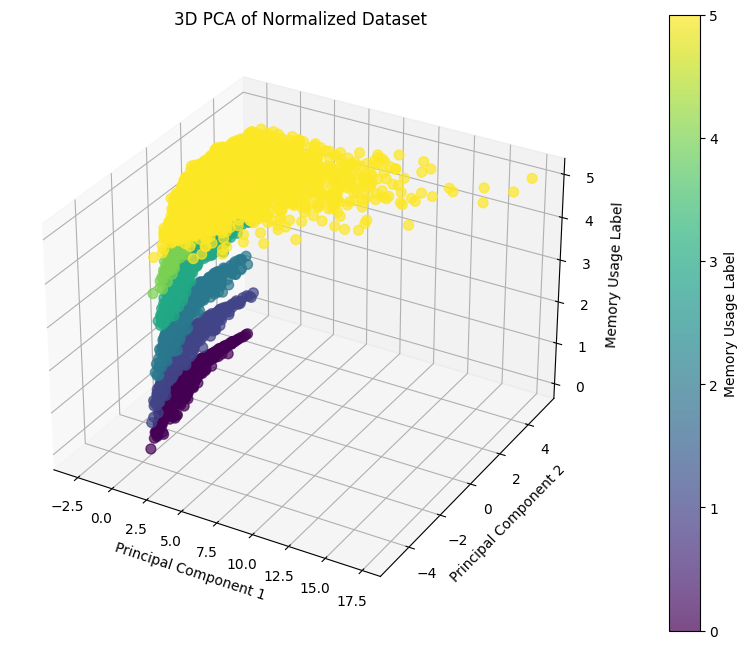

PCA Components:
[[ 0.38269384  0.31272889  0.1087365   0.40649392  0.24404724  0.14768617
   0.15037366  0.00167073 -0.00206964  0.21484776  0.40659826  0.3127289
   0.40671179]
 [-0.04350075 -0.36217284  0.43336075  0.18453221 -0.34094103 -0.20424238
  -0.17978114  0.00645704  0.00353959  0.50232287  0.18899573 -0.36217288
   0.18851199]
 [-0.02117623  0.0236432   0.04218087 -0.01267406  0.00956483 -0.0044019
  -0.01297216  0.70566571 -0.70564829  0.00540591 -0.01188485  0.02364336
  -0.01185246]]
Explained Variance Ratio:
[0.41094874 0.16091869 0.09975881]


In [30]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Import for 3D plotting
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assuming you have a pandas DataFrame 'df'
# df = pd.read_csv('your_dataset.csv')  # Uncomment if loading from a file

X = df[['Total Activations', 'Total Parameters', 'Batch Size', 'Total_Activations_Batch_Size',
                        'Conv2d Count', 'BatchNorm2d Count', 'Dropout Count', 'activation_encoding_sin',
                        'activation_encoding_cos', 'Input Size (MB)', 'Forward/Backward Pass Size (MB)',
                        'Params Size (MB)', 'Estimated Total Size (MB)']]
y = df['memory_usage_label']  # Output label for coloring

# Normalize the data
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Apply PCA to reduce the dataset to 2 dimensions
pca = PCA(n_components=3)  # Change to 3 components for 3D plotting
X_pca = pca.fit_transform(X_normalized)

# Plotting the PCA-reduced data in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], y, c=y, cmap='viridis', s=50, alpha=0.7)

# Labels and title
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Memory Usage Label')
ax.set_title('3D PCA of Normalized Dataset')

# Colorbar
cbar = plt.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label('Memory Usage Label')

# Show the plot
plt.show()

# Retrieve and display PCA components and explained variance ratio
components = pca.components_
explained_variance = pca.explained_variance_ratio_

print("PCA Components:")
print(components)

print("Explained Variance Ratio:")
print(explained_variance)


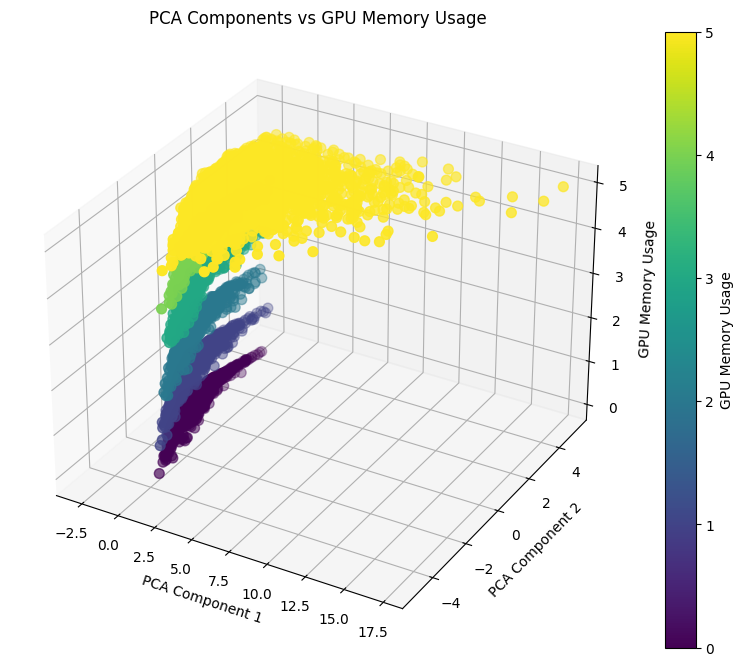

PCA Components:
[[ 0.38269384  0.31272889  0.1087365   0.40649392  0.24404724  0.14768617
   0.15037366  0.00167073 -0.00206964  0.21484776  0.40659826  0.3127289
   0.40671179]
 [-0.04350075 -0.36217284  0.43336075  0.18453221 -0.34094103 -0.20424238
  -0.17978114  0.00645704  0.00353959  0.50232287  0.18899573 -0.36217288
   0.18851199]]
Explained variance ratio:
[0.41094874 0.16091869]


In [31]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

# Example DataFrame columns: 'layers', 'batch_size', 'all_parameters', 'all_activations', 'memory_usage_label'
# Assuming you have a pandas DataFrame 'df'
# df = pd.read_csv('your_dataset.csv')  # Uncomment if loading from a file

# Prepare data
X = df[['Total Activations', 'Total Parameters', 'Batch Size', 'Total_Activations_Batch_Size',
                        'Conv2d Count', 'BatchNorm2d Count', 'Dropout Count', 'activation_encoding_sin',
                        'activation_encoding_cos', 'Input Size (MB)', 'Forward/Backward Pass Size (MB)',
                        'Params Size (MB)', 'Estimated Total Size (MB)']]
y = df['memory_usage_label']  # Actual GPU memory usage

# Normalize the data
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Apply PCA to reduce the dataset to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_normalized)

# Extract PCA components
pca1 = X_pca[:, 0]
pca2 = X_pca[:, 1]

# Plotting the PCA-reduced data with GPU memory usage as z-axis
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(pca1, pca2, y, c=y, cmap='viridis', s=50)
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('GPU Memory Usage')
ax.set_title('PCA Components vs GPU Memory Usage')

# Color bar
cbar = plt.colorbar(scatter, ax=ax, label='GPU Memory Usage')
plt.show()

# Output PCA components and explained variance ratio
components = pca.components_
explained_variance = pca.explained_variance_ratio_

print("PCA Components:")
print(components)

print("Explained variance ratio:")
print(explained_variance)


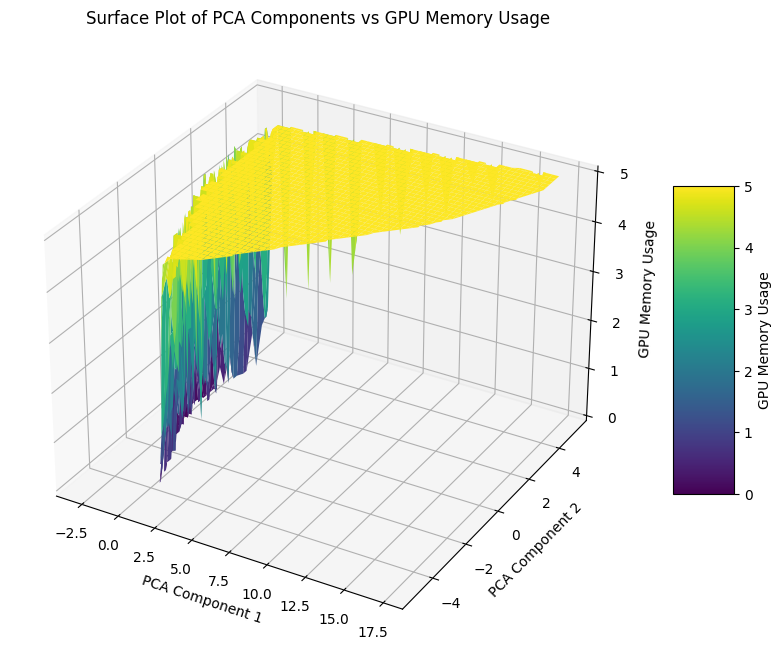

PCA Components:
[[ 0.38269384  0.31272889  0.1087365   0.40649392  0.24404724  0.14768617
   0.15037366  0.00167073 -0.00206964  0.21484776  0.40659826  0.3127289
   0.40671179]
 [-0.04350075 -0.36217284  0.43336075  0.18453221 -0.34094103 -0.20424238
  -0.17978114  0.00645704  0.00353959  0.50232287  0.18899573 -0.36217288
   0.18851199]]
Explained variance ratio:
[0.41094874 0.16091869]


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.interpolate import griddata

# Example DataFrame columns: 'layers', 'batch_size', 'all_parameters', 'all_activations', 'memory_usage_label'
# Assuming you have a pandas DataFrame 'df'
# df = pd.read_csv('your_dataset.csv')  # Uncomment if loading from a file

# Prepare data
X = df[['Total Activations', 'Total Parameters', 'Batch Size', 'Total_Activations_Batch_Size',
                        'Conv2d Count', 'BatchNorm2d Count', 'Dropout Count', 'activation_encoding_sin',
                        'activation_encoding_cos', 'Input Size (MB)', 'Forward/Backward Pass Size (MB)',
                        'Params Size (MB)', 'Estimated Total Size (MB)']]
y = df['memory_usage_label']  # Actual GPU memory usage

# Normalize the data
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Apply PCA to reduce the dataset to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_normalized)

# Extract PCA components
pca1 = X_pca[:, 0]
pca2 = X_pca[:, 1]

# Create grid for surface plot
pca1_grid, pca2_grid = np.meshgrid(np.linspace(pca1.min(), pca1.max(), 100),
                                   np.linspace(pca2.min(), pca2.max(), 100))

# Interpolate to fit the GPU memory usage on the grid
memory_usage_grid = griddata((pca1, pca2), y, (pca1_grid, pca2_grid), method='linear')

# Plotting the PCA-reduced data with GPU memory usage as a surface
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot surface
surf = ax.plot_surface(pca1_grid, pca2_grid, memory_usage_grid, cmap='viridis', edgecolor='none')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('GPU Memory Usage')
ax.set_title('Surface Plot of PCA Components vs GPU Memory Usage')

# Add color bar
cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
cbar.set_label('GPU Memory Usage')

plt.show()

# Output PCA components and explained variance ratio
components = pca.components_
explained_variance = pca.explained_variance_ratio_

print("PCA Components:")
print(components)

print("Explained variance ratio:")
print(explained_variance)

# regression model

In [33]:
columns_to_normalize = ['layers', 'batch_size', 'all_parameters', 'all_activations', 'batch_norm_layer', 'dropout_layers', 'activation_encoding_sin', 'activation_encoding_cos']

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler and transform the data
df_normalized_reg = pd.DataFrame(scaler.fit_transform(df[columns_to_normalize]), columns=columns_to_normalize)

# no normalization
# df_normalized = df

KeyError: "['layers', 'batch_size', 'all_parameters', 'all_activations', 'batch_norm_layer', 'dropout_layers'] not in index"

In [ ]:
from sklearn.model_selection import train_test_split
x_train_reg, x_temp_reg, y_train_reg, y_temp_reg = train_test_split(
    df_normalized_reg[['layers', 'batch_size', 'all_parameters', 'all_activations']].values, df_normalized_reg['real_memory_usage'].values, test_size=0.3, random_state=42)

x_test_reg, x_val_reg, y_test_reg, y_val_reg = train_test_split(
    x_temp_reg, y_temp_reg, test_size=0.66, random_state=42)

print('total data size: ', len(df_normalized))
print(f"train size {len(x_train_reg)}, val size: {len(x_val_reg)}, test size: {len(x_test_reg)}")

In [ ]:
train_dataloader_reg = DataLoader(CustomDataset(x_train_reg, y_train_reg), 64, num_workers=2, shuffle=True)
val_dataloader_reg = DataLoader(CustomDataset(x_val_reg, y_val_reg), 64, num_workers=2)
test_dataloader_reg = DataLoader(CustomDataset(x_test_reg, y_test_reg),1, num_workers=1)
x, y = next(iter(train_dataloader_reg))
print(f"input shape: {x.shape}, output shape: {y.shape}")

In [ ]:
class regression_gpu_usage(pl.LightningModule):
    def __init__(self):
        super(regression_gpu_usage, self).__init__()
        # Define your model
        self.model = FC_base(input_features=4, output_features=1, base_features=4)
        # self.criterion = nn.MSELoss()
        self.criterion = nn.L1Loss()
        # self.criterion = nn.CrossEntropyLoss()
        # self.criterion = nn.BCEWithLogitsLoss()


    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch[0], batch[1]
        # y = y.long()
        logits = self.forward(x)
        loss = self.criterion(logits, y)
        self.log('train_loss', loss, on_epoch=True, on_step=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch[0], batch[1]
        # y = y.long()
        logits = self.forward(x)
        loss = self.criterion(logits, y)
        self.log('val_loss', loss, prog_bar=True, on_epoch=True, on_step=True)
        return loss

    def configure_optimizers(self):
        # Create a quantized optimizer
        optimizer = Adam(self.parameters(), lr=0.0001)

        # # Use a scheduler that doesn't require setting the learning rate explicitly
        # scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)
        # return {
        #     'optimizer': optimizer,
        #     'lr_scheduler': {
        #         'scheduler': scheduler,
        #         'monitor': 'val_loss',
        #         'frequency': 1
        #     }
        # }
        return optimizer



In [ ]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=True, mode='min')
# logger = TensorBoardLogger("logs")
# Create a checkpoint callback

# checkpoint_callback = ModelCheckpoint(
#     dirpath=config['model_save_dir'],
#     filename=f"{config['modality_type']}",
#     save_top_k=1,
#     verbose=True,
#     monitor='val_loss',
#     mode='min'
# )

# Initialize the model
regression_model = regression_gpu_usage()
regression_model.train()
# Initialize the trainer with mixed precision (AMP) and early stopping
trainer = pl.Trainer(
    # logger = logger,
    max_epochs=200,  # you can set this higher, early stopping will halt training
    callbacks=[early_stopping],
    # precision='16-mixed',  # Use AMP
    # accelerator='gpu',  # Use GPU if available
    # devices=1  # Number of GPUs
)

# Train the model
trainer.fit(regression_model, train_dataloaders=train_dataloader_reg, val_dataloaders=val_dataloader_reg)



In [ ]:
regression_model.eval()
pred_list, gt = list(), list()
with torch.no_grad():
    for test_data in test_dataloader_reg:
        pred = regression_model(test_data[0])
        # print(f"prediction: {torch.argmax(pred, 1)}, ground truth: {test_data[1]}")
        gt.append(test_data[1].item())
        pred_list.append(pred.item())
        print(f"prediction: {pred.item()}, gt: {test_data[1].item()}")

plt.figure(figsize=(15, 3))
plt.scatter(range(1, len(pred_list) + 1), pred_list, label="predicted")
plt.scatter(range(1, len(gt) + 1), gt, label="actual value")
plt.legend()